# Predicting Bank Client's Financial Product subscription using Scikit Learn and XGBoost for imbalance dataset.

   - [Alok N Singh](https://github.com/aloknsingh/)

# Table of Contents
1. [Introduction](#introduction)
        
2. [Data Set](#dataset)   

3. [Statement of Classification Problem](#pb_statement)

4. [Software and Tools(Xgboost and Scikit Learn)](#software_tools)

5. [Data Exploration](#data_exploration)

6. [ML Pipelines for Data Processing](#ml_pipeline)

7. [Model Training](#model_training)

   7.1 [What and Why of XGBoost](#xgboost)
   
   7.2 [Metrics for Model Performance](#metrics_perf)
   
   7.3 [First Attempt at Model Training](#ml_train_1)
   
   7.4 [Strategy For Better Classifier for the Imbalance Data](#ml_clf_strategy)
   
   7.5 [Second Attempt at Model Training using Weighted Samples](#ml_train_2)
   
   7.6 [Third Attempt at Model Training using Weighted Samples and Feature Selection](#ml_train_3)

8. [Generalization and Prediction](#prediction)

9. [Summary](#summary)

10. [Pointers to Other Advanced Techniques](#other_techniques)

10. [References](#references)
    

# Introduction <a name="introduction"></a>


We will illustrates the Machine Learning classification using the Gradient Boosted Tree. Gradient Boosted Tree,
is usually a better choice compare to the logistic regression and other techniques. We will use the real life data set which is highly imbalance i.e the number of positive sample is much less than the number of negative samples.

We will walk the user to the the following conceptual steps

* Data Set Description.
* Exploratory Analysis to understand the data.
* Use various preprocessing to clean and prepare the data.
* Use naive XGBoost to run the classification.
    * Use cross validation to get the model.
    * Plot, precision recall curve and ROC curve.
* We will then tune it and use weighted positive samples to improve classification performance.
* We will also talk about the following advanced techniques.
    * Oversampling of majority class and Undersampling of minority class.
    * SMOTE algorithms.


# Data Set <a name="dataset"></a>

We will use the dataset from [UCI repository for Bank Marketing Data Set](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

The source of the dataset is 

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


## Data Set Infromation

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 


### Feature Information

###### A. Bank Client Information
| col num| feature name| feature description |
|--------|:-----------:|:--------------------|
|1|  **age** |(numeric)|
|2|  **job** | type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')|
|3| **marital**| marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)|
|4| **education** |(categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')|
|5| **default**| has credit in default? (categorical: 'no','yes','unknown')|
|6| **balance**| how much credit card balance|
|7| **housing**| has housing loan? (categorical: 'no','yes','unknown')|
|8| **loan**| has personal loan? (categorical: 'no','yes','unknown')|




###### B. Attributes related with the last contact of the current campaign

| col num| feature name| feature description |
|--------|:-----------:|:--------------------|
|9|**contact**| contact communication type (categorical: 'cellular','telephone')| 
|10|**day**| last contact day of month (categorical: '1', '2', '3', ..., '30', '31')|
|11|**month**| last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')|
|12|**duration**|last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.|

###### C. other attributes

| col num| feature name| feature description |
|--------|:-----------:|:--------------------|
|13|**campaign**|number of contacts performed during this campaign and for this client (numeric, includes last contact)|
|14|**pdays**|number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)|
|15|**previous**|number of contacts performed before this campaign and for this client (numeric)|
|16|**poutcome**|outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') |



###### E. Output variable (desired target) 
| col num| feature name| feature description |
|--------|:-----------:|:--------------------|
|17|**y**| has the client subscribed a term deposit? (binary: 'yes','no')|






# Statement of the Classification Problem  <a name="pb_statement"></a>

Now we know the schema of the dataset, lets formalize our model building task.

1) We will build a machine learning model to predict if a client is likely to subscribed to the a financial product i.e term deposit.



### Challenges in building ML model

There are many challenges in the machine learning. For example --

   * Non Representative data

   * Insufficient data.

   * Poor quality data.
   
   * Imbalance data set.

   * Irrelevant features.

   * Overfitting the model on data

   * Underfitting of the model on data

   * Whether model will generalize or not

   We will explore many of them as we proceed. 



# Software and Tools (Xgboost and Scikit Learn) <a name="software_tools"></a>

##### Python Package Dependencies

We will use the [scikit learn package](http://scikit-learn.org/stable/documentation.html) for this task. Next few cells load the libraries needed for this notebook. 


In [1]:
# load pandas for 
##   1. reading various files into the dataframe
##   2. to performa various data manipulation tasks

import pandas as pd

# load numpy
import numpy as np

In [2]:

# for preprocessing
from sklearn import preprocessing

# for custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# for creating pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

# for cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score

# for various metrics and reporting
from sklearn import metrics 
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# feature selection
from sklearn.feature_selection import SelectFromModel

# xgboost library
from xgboost import XGBClassifier

# plot feature importance
from xgboost import plot_importance, plot_tree




In [3]:
# load matplot lib for various plotting
import matplotlib.pyplot as plt
plt.rc("font", size=14)

# we will use the seaborn for visually appealing plots
import seaborn as sns
sns.set() # set the seaborn stylesheet
#sns.set(style="white")
#sns.set(style="whitegrid")

# Data Exploration <a name="data_exploration"></a>


First step to build predictive model, is to explore data set so that one can get as much insight as possible so that we can do better feature engineering.

##### Data Set loading 

We will use [pandas](https://pandas.pydata.org/) to read data and create dataframe. 
   
   * Pandas support a lot more functionalities for analysis than reading and writing the dataframe. We will use a few of them.


In [4]:
#following code is for IBM Watson Studio loading. note if you are not using Watson studion , 
# one can skip this.

import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_9ebc573937b647fdaea67b50c5ffa1e9 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='U2v61-Sy7j8htddu5cFZJe9EEgUeCqILurs3Vj9nn-4B',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

#body = client_9ebc573937b647fdaea67b50c5ffa1e9.get_object(Bucket='pythondatasciencenotebooks238af3dbc1384aaebbcd5465d478db62',Key='bank.csv')['Body']
body = client_9ebc573937b647fdaea67b50c5ffa1e9.get_object(Bucket='pythondatasciencenotebooks238af3dbc1384aaebbcd5465d478db62',Key='bank.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

#df_data_1 = pd.read_csv(body)
#df_data_1.head()

data_raw_all = pd.read_csv(body, header=0, sep=";")

data_raw_all.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [5]:
# load csv file
# if you are using notebook on your laptop. use following to load
#data_raw_all = pd.read_csv("bank.csv", header=0, sep=";")

In [6]:


# preview 
print("(num_rows, num_cols) =", data_raw_all.shape)
print("attributes =", list(data_raw_all.columns))

print ("\n\n'Bank data set preview'")
data_raw_all.head()

# schema
print("'Data set schema'")
data_raw_all.dtypes



(num_rows, num_cols) = (4521, 17)
attributes = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


'Bank data set preview'
'Data set schema'


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

## Data Exploration using Seaborn and Matplotlib

Lets start with data exploration. As we explore, we hope to 

* Look at big picture.
* Get insights into the data and problem. 
* If possible, redefine the problem statement based.


Usually, for exploratory analysis, one samples input dataset. However, our dataset is small and hence
we will put the sample fraction to be 1.0. For the bigger dataset, one may want to change fraction accordingly.


In [7]:
# clean data
## cleaning routines
def clean_data(df):
    """
     Clean the data for the exploratory analysis
     
     arguements:
     df -- pandas dataframe.
     
    """
    # drop the missing data row
    data = df.dropna()
    
    # first convert the day type to object as day is not of int64 type but a categorical type
    data['day'] = df.astype('object')

   
    return data

# 
data_ex = clean_data(data_raw_all.sample(frac=1.0))


### Explore output


##### Positive and Negative Class Distribution.

We know the output i.e client response 'y' can be 'yes' or 'no'. Lets see it's relative frequencies.
Since we are interested in predicting when client is going to purchase a term deposit, out positive sample is 'yes' and
negative samples is 'no'


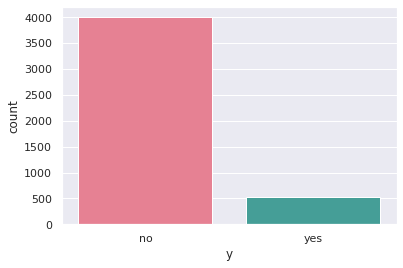

In [8]:
sns.countplot(x='y', data=data_ex, palette='husl')
plt.show()


we can see that we have class imbalances between positive and negative classes (positive samples are around 10% and negative samples are around 90%). The class imbalance is very common in the real dataset. We will see that this imabalance causes problem in our model performance. However we will also explore ways to mitigate it.



#####  Check if there is the class skew wrt other numerical columns

Lets see for the numeric column, on average if there is a pattern in the two classes.


In [9]:
# mean of the numeric features and how it effects output

data_ex.groupby('y').mean()

,age,balance,duration,campaign,pdays,previous
y,,,,,,
no,40.998000,1403.211750,226.347500,2.862250,36.006000,0.471250
yes,42.491363,1571.955854,552.742802,2.266795,68.639155,1.090211



We note that:

   *  age, balance, day, compaign are balanced between 'yes' and 'no' classes and hence probably not the best predictors
   *  duration feature as explained in the dataset shouldn't be used for prediction and we will not analyse this feature
   *  pdays feature indicates that usually the conversion happens if the client are contacted not frequently
   *  previous feature indicates that more the number of times client are contacted more likely he will be a positive sample.
    
    

###  Explore the inputs

We can get many insights into the data set by exploring the inputs i.e features.


###### Distribution and corelation of the numeric columns

Lets plot the distribution of the features and their cross co-relation to get the information about reduntant features.


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'marker'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/nonparametric/kernels.py:125: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/nonparametric/kernels.py:125: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/matplotlib/contour.py:1483: UserWarning: Warni

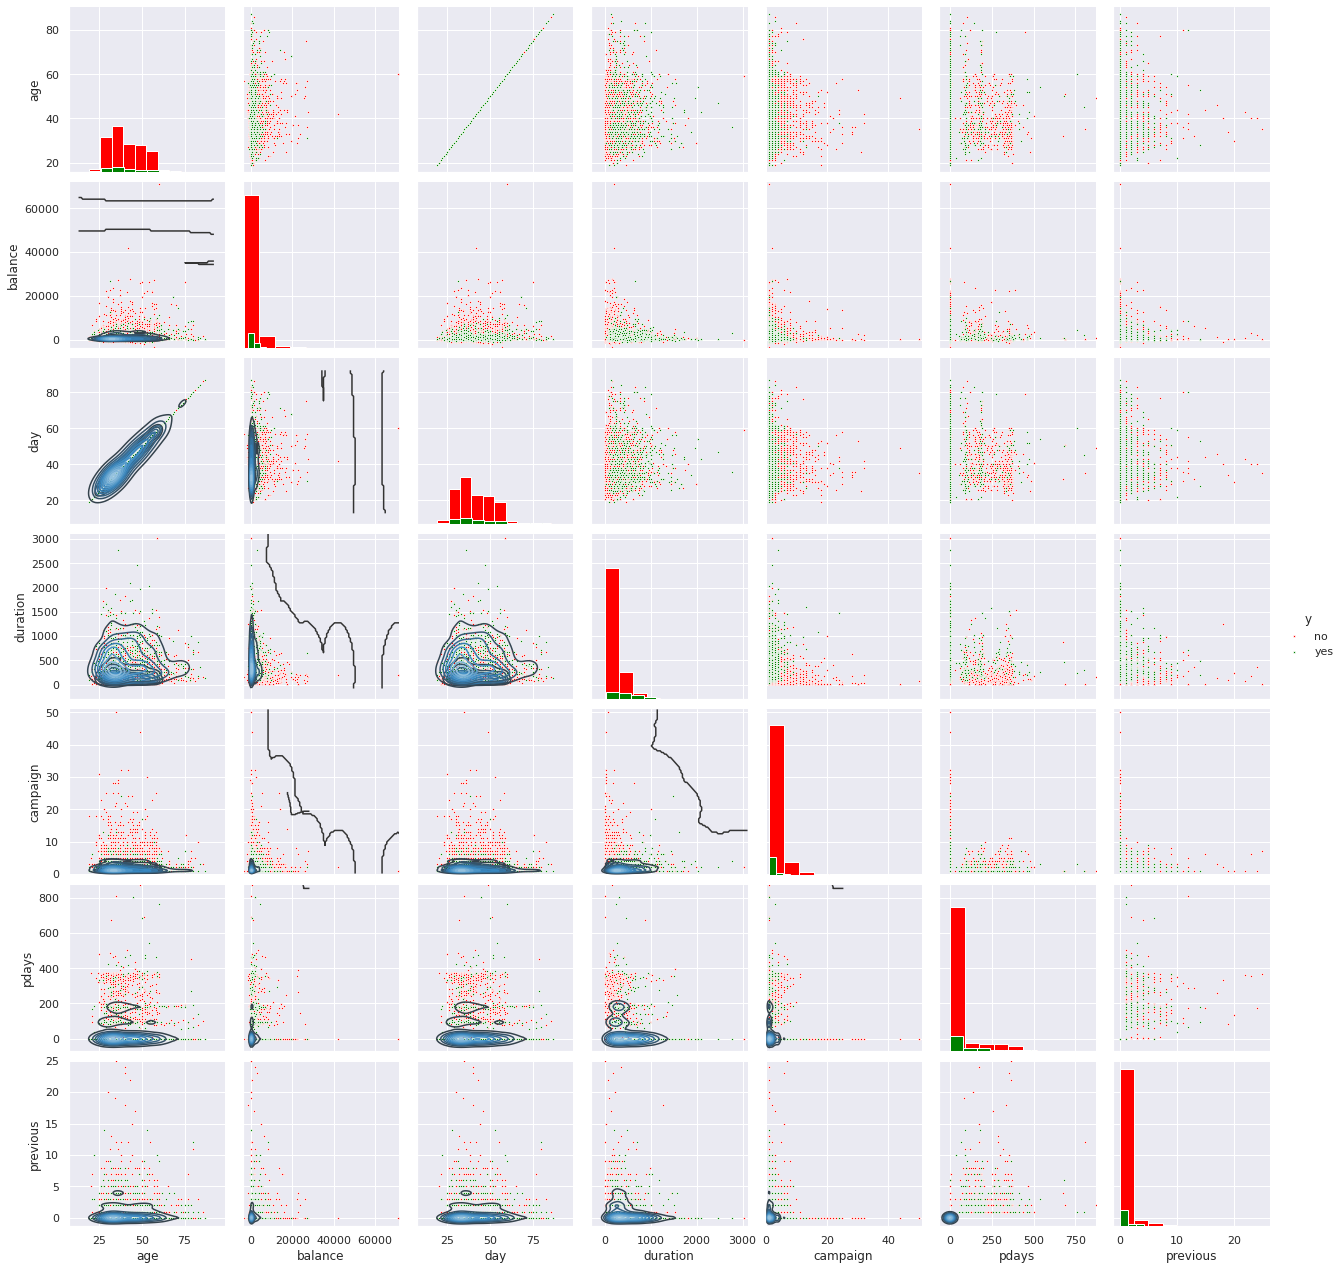

In [10]:
# create the scatter plot.
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

num_cols_with_y = num_cols + ['y']

g = sns.pairplot(data_ex[num_cols_with_y], 
                 hue = 'y',  # yes is green and 
                 diag_kind='hist',  # histogram plot for diag
                 dropna=True,
                 markers=[',', ','], # markers for yes and no                 
                 palette=sns.color_palette(['red', 'green']), # # yes is green and no is red
                 plot_kws={
                     's':3 # size of the point
                 },
                 
                )
g = g.map_lower(sns.kdeplot, cmap="Blues_d")


plt.show()

We observe the following insights

* All the columns of interests (i.e diagonal plot) has the predictive power (as none of them are uniform). 

* The class imbalance is high (i.e green color 'yes' is far less than red colored 'no' in the diag plot)

* Non diagonal lower matrix plot contains contour plot for pairwise features.

* Non diagonal upper matrix plot contains the corelation between pairwise corelation. For example cell (1 rst row, 3rd column) shows that there is some corelation between 'age' and 'days' feature. So to get the better feel, we will plot the heat map co-relation matrix also.


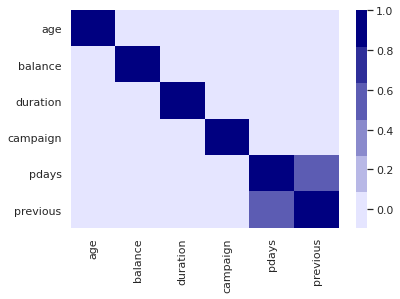

In [11]:
# find the corelation between inputs
corr = data_ex[num_cols].corr()

# plot heatmap
sns.heatmap(corr, 
            xticklabels=corr.columns.values, yticklabels=corr.columns.values,
            cmap=sns.light_palette("navy"),
           )
plt.show()

We note that:

* pdays and previous features are correlated heavily and we should use one of them



We did various exploratory analysis to get more insights into the dataset.


## Create a Test and Train Set.

Now it is time to split aside the train and test dataset. Why is it that we makes this decision at this stage?
Since if we don't do it and train our model on the whole dataset and then test it on the part of the dataset, we are testing on the subset of data which was used for training and hence we will never know whether our model generalizes well or not.





To split the dataset into training and testing, we will use scikit learn's utility [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). It works also with pandas dataframe and we don't have to do any conversion from pandas to numpy data type.

For Model Training, we will sub-split train set and only in the end, we will use test set for generalization test.


In [12]:

# 10 percent of dataset is used for test and 90 percent for model training
data_raw, data_raw_test = train_test_split(data_raw_all, test_size=0.1, random_state=0)

#
print("Size of the training dataset = ", data_raw.shape)
print("Size of the testing dataset = ", data_raw_test.shape)
print("\nSample of the training dataset \n")
data_raw.head()

Size of the training dataset =  (4068, 17)
Size of the testing dataset =  (453, 17)

Sample of the training dataset 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1511,34,unemployed,single,secondary,no,0,no,no,cellular,17,nov,63,2,-1,0,unknown,no
1119,28,management,single,tertiary,no,4937,yes,no,telephone,13,may,421,3,-1,0,unknown,no
3750,79,retired,divorced,unknown,no,2628,no,no,telephone,8,jul,220,7,450,2,failure,no
2868,40,services,married,secondary,no,771,yes,no,cellular,15,may,173,4,-1,0,unknown,no
2758,57,admin.,married,tertiary,no,46,no,no,cellular,7,aug,238,2,-1,0,unknown,no


# ML Pipeline for Data Processing <a name="ml_pipeline"></a>



Next, we will preprocess the data so that it is more suitable for input to the scikit learn algorithms.

* we will use scikit learn transformer and pipeline to create the ML pipeline. This will allow us to use 
 the pro-processing ml pipeline to apply to both training and test dataset. 

* We will implement ml pipeline for X (i.e the input feature set) and y for the output. We will use various transformer from scikit learn and as well as use our custom transformer

    * clean and split the dataset

    * encode the categorical features. 
    
    * combine the various new features to create new X.
    

### Create Helper functions

Model training is the iterative process and we would now build various helper function which will be used later on multiple times. We will explain the details while developing each of helper utilities.


##### split dataset into data numeric and categorical attributes

Lets create the utility to split the input features to categorical and numerical features. 

In [13]:

def get_data_attrs_names(data):
    """
     get the categorical inputs and numerical inputs and output column names.
     We use the dtype of the data to decide between numerical and categorical attribut
     
     arguements:
     data -- pandas dataframe.
     
     return:
     a dict with the following keys and values
     y: list of of the target attribute
     X_cat: list of categorical inputs i.e dtype == object
     X_num: list of numerical inputs i.e dtype != object 
     X: list of the combied {X_num, X_cat} inputs
    """
        
    all_attribs = list(data.columns.values)
    target_attrib = ['y']

    # seperate out output column
    y = data[target_attrib]
    print("\n\nsample of 'target i.e output attributes'")
    print(y.head())

    data_cat = data.select_dtypes(include=['object']).copy()
    data_cat = data_cat.drop(target_attrib[0], axis=1)
    cat_attribs = list(data_cat.columns.values)
    print("\n\n'sample of categorical attribute and output attributes'")
    print(data_cat.head())

    # sep out continous aka scale columns
    data_scale = data.select_dtypes(include=[np.number]).copy()
    num_attribs = list(data_scale.columns.values)
    print("\n\n'sample of continous (scale) attributes'")
    print(data_scale.head())

    # col_X contains all the predictors
    X_attribs = list(all_attribs) # copy all cols names
    X_attribs.remove(target_attrib[0])

    res = {
        'y': target_attrib,
        'X_cat': cat_attribs,
        'X_num': num_attribs,
        'X': X_attribs
    }
    return res
    

    
attrs_map = get_data_attrs_names(data_raw)   
print("\n\n names of the attributes splited according to type\n")
print(attrs_map)



sample of 'target i.e output attributes'
       y
1511  no
1119  no
3750  no
2868  no
2758  no


'sample of categorical attribute and output attributes'
             job   marital  education default housing loan    contact month  \
1511  unemployed    single  secondary      no      no   no   cellular   nov   
1119  management    single   tertiary      no     yes   no  telephone   may   
3750     retired  divorced    unknown      no      no   no  telephone   jul   
2868    services   married  secondary      no     yes   no   cellular   may   
2758      admin.   married   tertiary      no      no   no   cellular   aug   

     poutcome  
1511  unknown  
1119  unknown  
3750  failure  
2868  unknown  
2758  unknown  


'sample of continous (scale) attributes'
      age  balance  day  duration  campaign  pdays  previous
1511   34        0   17        63         2     -1         0
1119   28     4937   13       421         3     -1         0
3750   79     2628    8       220         7    4


##### create transformer to select the subset of data

We will extends [BaseEstimator](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) and [TransformerMixin](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) classes from scikit library to create a transformer which will
select a list of the columns corresponding to attribute_names.

We will use this transformer later to create the pipeline for inputs as well as output.


In [14]:

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        """
        custom transformer to select the columns 
        arguements: 
        attribute_names -- name of the attributes to select
        """
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        """no processing to be done for fit"""
        return self
    
    def transform(self, X):
        """
        returns the subset of the columns corresponding to the attribute_names
        X -- input dataset
        return -- selected data columns from X
        """
        return X[self.attribute_names].values
    
    
    
    

In [15]:
class DataFrameCatImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        custom categorical imputer
        source : https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
        Columns of dtype are imputed with the most frequest value in the column
        """
        pass
    
    def fit(self, X, y=None):
        for c in X:
            print("al", c)
            
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)
        
        return self
    
    def transform(self, X):
        return X.fillna(self.fill)
    

##### Create Transformer to create categorical encoding

Since ML algorithms works with numbers, we would like to map string or categorical inputs to integers. However, if we map the categorical features to integer than we might be biasing the data.For example, if we map maritial status ('single', 'married', 'divorced', 'unknown') to (0, 1, 2, 3), then we are giving divorced values to have more weights and it is not we intended, so ideally we would like to map categerical values to one hot encoding. 


Scikit learn has transformers called [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) and [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and we could them together to do encoding of categorical features.

However, as of scikit-learn 0.19 version, the LabelEncoder and OneHotEncoder transformer can't be used in the Scikit learn together in a pipeline due to a bug.
The bug has been fixed in the dev branch of scikit learn by [PR9151](https://github.com/scikit-learn/scikit-learn/pull/9151) and will be available in future releases. Until then, we will just copy paste the content of class CategoricalEncoder.

The following transformer is just copy pasted from the 
dev branch and we recommend user not to go into the details for the purpose of this notebook


In [16]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out


##### Create Transformer to create label encoding for output

As explained in the previous section, there seems to be a bug in scikit learn current version which doesn't allow
Label encoder to be used in a ML pipeline. To solve that we will create our custom transformer, which is same as the 
original one i.e LabelEncoder but with the signature of fit and transform different. 



In [17]:
## custom LabelEncoder as the org doesn't work
class MyLabelEncoder(preprocessing.LabelEncoder):
    """
     custom LabelEncoder as the org doesn't work with the pipeline
    """
    def fit_transform(self, X, y=None):
        return super(MyLabelEncoder, self).fit_transform(X)
    
    def fit(self, X, y=None):
        return super(MyLabelEncoder, self).fit(X)
    
    def transform(self, X):
        return super(MyLabelEncoder, self).transform(X)

##### Utility for ML pipeline for X i.e input features


The idea of combining various transformers into a pipeline allows scikit users to create complex data and ML processing
pipeline. For the input features we will do the following 

* Numeric attributes: 
    * select numerical attributes.
    * impute missing values of a feature using the median of the feature.
    * scale values of a feature by shifting it by it's mean and dividing by standard deviation.
* Categorical attributes:
    * select categorical attributes.
    * for each of the columns perform one hot encoding
* Feature Union:
    * combine the columns from numeric and categorical attributes to create the processed input dataset i.e X
    

In [18]:
from sklearn.impute import SimpleImputer
def create_X_ml_pipeline(cat_attrs, num_attrs):
    """
    Create ml pipeline for the features by first processing numerical and then categorical attribute.
    Afterwards, it combines those to create final transformed X attribute.
    
    arguement:
    cat_attrs -- list of categorical attribute
    num_attrs -- list of numerical attribute
    
    return: a full X ML pipeline, which can be used for train and test data
    """
    
    num_pipeline = Pipeline([
       ('selector', DataFrameSelector(num_attrs)),
       ('imputer', SimpleImputer(strategy="median")),
       ('std_scaler', preprocessing.StandardScaler()),
    ])

    cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attrs)),
        ('cat_enc', CategoricalEncoder(encoding="onehot-dense")),
    ])
    
    full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
    ])
    
    return full_pipeline


    


##### Utility for  ML pipeline for Y i.e output features


Output contains 'yes' and 'no' values and should be mapped to numerical values. Lets us custom transformer MyLabelEncoder for this purpose. Also we will be use our custom transformer DataFrameSelector to select output column.



In [19]:

def create_y_ml_pipeline(target_attr):
    """
    create ml pipeline for the output feature i.e target attribute by first selecting it and mapping 'no' and 'yes' to
    0 and 1
    arguements:
    target_attr -- list of outputs.(Usually a list containing one value)
    return:
    a full y ML pipeline, which can be used for train and test data
    """
    target_pipeline = Pipeline([
        ('selector', DataFrameSelector(target_attr)),
        #('cat_imputer', DataFrameCatImputer()),
        ('label_enc', MyLabelEncoder()),
    ])
    
    return target_pipeline


##### Create and run the ML pipeline for X and y

Now we have defined the function for creating ML pipelines, lets us it to create X and y ML pipeline.


First lets create the X ML pipeline and print it's values.
Readers should note that the values are all scaled and one hot encoded.


In [20]:
## run the pipeline

X_pipeline = create_X_ml_pipeline(attrs_map['X_cat'], attrs_map['X_num'])
X_pipeline = X_pipeline.fit(data_raw)
X = X_pipeline.transform(data_raw)


print("\n\nShape of the transformed data. Note that increased in the number of columns due to one hot encoding\n")
print("\nOriginal data shape (num_rows, num_cols) == ")
print(data_raw.shape)
print("\nTransformed data shape (num_rows, num_cols) == ")
print(X.shape)
print("\n\n Sample of transformed inputs\n", X, "\n")




Shape of the transformed data. Note that increased in the number of columns due to one hot encoding


Original data shape (num_rows, num_cols) == 
(4068, 17)

Transformed data shape (num_rows, num_cols) == 
(4068, 51)


 Sample of transformed inputs
 [[-0.6734285  -0.4727389   0.12702873 ...  0.          0.
   1.        ]
 [-1.23973489  1.14925852 -0.35693557 ...  0.          0.
   1.        ]
 [ 3.57386941  0.39066179 -0.96189094 ...  0.          0.
   0.        ]
 ...
 [ 1.11987506 -0.37220594  1.45793055 ...  0.          1.
   0.        ]
 [-0.8621973  -0.26181681 -0.96189094 ...  0.          0.
   1.        ]
 [ 0.36479988 -0.57852848 -0.84089986 ...  0.          0.
   1.        ]] 



In [21]:

print("Output attribute name = ", attrs_map['y'], "\n")

y_pipeline = create_y_ml_pipeline(attrs_map['y'])
y_pipeline = y_pipeline.fit(data_raw)
y = y_pipeline.transform(data_raw)


print("\nSample of original output = ", data_raw['y'].values.reshape(-1)[:20], "\n")
print("\nSample of transformed output = ", y[:20], "\n")


Output attribute name =  ['y'] 


Sample of original output =  ['no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes'
 'yes' 'no' 'no' 'no' 'yes' 'no'] 


Sample of transformed output =  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0] 



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


# Model Training <a name="model_training"></a>

we have transformed dataset using our custom ML pipelines and are ready to build the model. There are many ML models in python. We will use [XGBoost](http://xgboost.readthedocs.io/en/latest/). 


### What and Why of XGBoost. <a name="xgboost"></a>

* XGBoost is extreme gradient boosting algorithm based on trees and tends to perform very good out of the box compare to other ML algorithms.
* XGBoost is popular amongt data-scientist and one of the most common ML algorithms used in [Kaggle](https://www.kaggle.com/) Competitions.
* XGBoost allows one to tune various parameters.
* XGBoost allows parallel processing.
* Here is the official tutorial, which explains in details [XGBoost Tutorial 1](http://xgboost.readthedocs.io/en/latest/model.html) and also [XGBoost tutorial 2](https://www.slideshare.net/ShangxuanZhang/kaggle-winning-solution-xgboost-algorithm-let-us-learn-from-its-author) is excellent.

Though above tutorial is very detail, here we present the basic of XGBoost for the sake of continuation of the text.

XGBoost was developed by Tianqi Chen.XGboost is a class of ML algorithms which uses Gradient Boosting.

Gradient Boosting in  is an ensemble techniques, at each steps new models are added to correct the errors made by current existing models and thus models are added sequentially until no more improve is possible.

Each of the tree model is classification and regression tree (CART). The ensemble of  prediction of multiple trees gives better result compare to the individual tree.


The objective of XGBoost model is given by 


| Objective => | **Obj** **= Loss + Regularization**|
|-----|:------------------------|
|**Loss** | is the loss function that controls the predictive power. Usually logloss for classification and RMSE loss for regression.|
|**Regularization**| controls simplicity and overfitting and depends on the number of leaves|



##### Create the utils for instantiating classifier with correct options

Since we will be instantiating XGBoost classifier multiple times for doing the cross validation and tesitng. Lets create a utility for instantiating the classifier.


Here are the explaination in reference to our dataset for each tuning parameters we will use. (Note: also see [XGBoost parameter official guide](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md)

| xgboost parameter | description |
|:------|:------------|
|**booster**| select the type of model to run at each iternation we have the options of tree and linear models|   
|**objective**|since we want the output to have the probability also, we will use the logistic objective.|   
|**eval_metric**|lets use the error as the eval metrics i.e in each boosting steps we will reduce error.|   
|**eta**|eta is like learning rate and it makes the model more robust by shrinking the weights at each iteration.|   
|**gamma**|gamma controls the minimum loss reduction to split and it should be tuned.|
|**max_depth**|maximum depth of a tree to control the over fitting. should be tuned with cv|
|**min_child_weight**|minimum number of samples for the leaf and is used to control overfitting. We will use lower values, as we have class imbalance and if we set high then accuracy of minory class will be affected.|   
|**max_delta_step**|maximum delta step from previous iteration for each tree. Higher the value (i.e non zero), more conservative we are!| 
|**subsample**|as explained before in boosting each tree is build using samples from prev iteration with replace and this specify the fraction of data to be used for each tree. typically values slightly less than 1 makes it robust.|
|**colsample_bytree**|as explained before boosting use subset of rows and also subset of columns. this controls the subset of cols as fraction.|
|**silent**|control the verbosity.|
|**seed**|random seed for reproducibility.| 
|**base_score**|set the initial prediction score i.e global bias.| 
|**scale_pos_weight**|how much weight to give the positive sample, in future we will change it but for now lets put it 1|

    

In [22]:

def create_xgb_clf(clf_param=None):
    
    """
    create the xgboost classifier with predefined parameters, user can overwright it by passing kw args
    """
   
    param = {}
    # select the type of model to run at each iternation we have the options of tree and linear models
    ##param['booster'] = 'gbtree'
    
    # since we want the output to have the probability also, we will use the logistic objective.
    ##param['objective'] = 'binary:logistic'
    
    # lets use the error as the eval metrics i.e in each boosting steps we will reduce error
    ##param["eval_metric"] = "error"
    
    # eta is like learning rate and it makes the model more robust by shrinking the weights at each iter
    ##param['eta'] = 0.3
    
    # gamma controls the minimum loss reduction to split and it should be tuned.
    ##param['gamma'] = 0

    # maximum depth of a tree to control the over fitting. should be tuned with cv
    ##param['max_depth'] = 10
    
    # minimum number of samples for the leaf and is used to control overfitting. We will use lower values, as we have
    # class imbalance and if we set high then accuracy of minory class will be affected
    ##param['min_child_weight']=1
    
    # maximum delta step from previous iteration for each tree. Higher the value (i.e non zero), more conservative we are
    ##param['max_delta_step'] = 0
    
    # as explained before in boosting each tree is build using samples from prev iteration with replace and this specify 
    # the fraction of data to be used for each tree. typically values slightly less than 1 makes it robust.
    ##param['subsample']= 1
    
    
    # as explained before boosting use subset of rows and also subset of columns. this controls the subset of cols as fraction
    ##param['colsample_bytree']=1
    
    # control the verbosity
    ##param['silent'] = 0
    
    # random seed for reproducibility
    ##param['seed'] = 0
    
    # set the initial prediction score i.e global bias 
    ##param['base_score'] = 0.5
    

    
    
    # how much weight to give the positive sample, in future we will change it but for now lets put it 1
    param['scale_pos_weight']= 1

    if clf_param:
       for k, v in clf_param.items():
          param[k] = clf_param[k]
            
    xgb_model = XGBClassifier(**param)
    return xgb_model




### Metrics for Model Performance <a name="metrics_perf"></a>

To come up with the best model, we should evaluate model performance for comparison amongs models.There are many ways to evaluate the model performance for classification.

1) Accuracy Score

2) Confusion Matrix

3) ROC curve

4) Precision Recall Curve

We will discuss and create utilities for the above in next few sections




###### Accuracy Score
Accuracy is just the ratio of the number of correctly classified samples to the total number of samples.
This is very simple score but it in case of the class imbalance, the score can be misleading. Hence, we 
will not use this.


#####  Confusion Matrix

Apart from the accuracy, the following performance measures for the models are also very helpful to measure it's performance on test dataset.

* The number of samples correctly predicted as negative i.e True Negative (TN).

* The number of samples correctly predicted as positive i.e True Positive (TP). These are also used in accuracy calculation.

* The number of samples which were positive but were predicted as negative i.e False Negative (FN).

* The number of samples which were negative but were predicted as positive i.e False Positive (FP).

[Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) gives above mentioned metrics of performance and is widely used for classification task.

We have created a utility to visualize confusion matrix based on the dataset.


In [23]:
#plot the confusion matrix
def plot_cm(y_test_act, y_test_pred, title="Confusion Matrix", cmap="Blues"):
    """
    plot the confusion matrix given the test label and predicted label.
    
    @arguements:
    y_test_act -- actual label (0 or 1) of the data set.
    y_test_pred -- model's predicted label (o or 1) of the data set.
    title -- title string to be put on plot. default -- Confusion Matrix
    cmap -- matplotlib color palette to be used. default -- Blues
    """
    
    fig, ax = plt.subplots()
    cm = confusion_matrix(y_test_act, y_test_pred)
    tp = cm[1,1]
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap = cmap, ax = ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("Actual class")
    plt.show()
    
 


###### ROC curve

Lets see what is ROC curve? We can get the TP, TN, FN, FP from confusion matrix as explained in previous section. ML models also gives us the probability of a sample being a positive or negative.  This allows us to make the better decision. 

For ROC curve, we use 

**TPR** : True Positive Rate (aka Recall) = $ \frac{TP}{(TP+FN)} $ i.e number of samples, model correctly classifies a positive sample as positive.

**FPR** : False Positive Rate (aka Specificity) = $\frac{FP}{(FP + TN)}$ i.e number of samples, model incorrectly classifies a negative sample as positve.

obviously, we would like to have higher TPR and lower FPR.

For example, consider two predicted positive samples, one with 0.55 probability and other with 0.95 probability.
These samples are considered positive  because by default the threshold is 0.5. 
If we use the threshold of 0.6 then first sample will be negative and the second will be positive. 

In short, the values of TP, FP, TN, FN will change depending on the threshold.

Thus we see that by adjusting the threshold, one can change the model's performance and for binary classification this adjustment is very often done. When we adjust the threshold, the value of TPR and FPR will also change, as they are function of TP, FP, TN, FN and when we plot TPR vs FPR for various threhold, we get the ROC curve. 

For a model to have best performance, we would like to have model rank a randomly chosen positive sample higher than a randomly chosen negative samples and this is what we call Area Under the Curve (AUC) metric.

For more information visit wiki for [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).


##### Precision Recall Curve

We have a good measure for measuring model performance using ROC curve. However, when we have the class imbalances, ROC curve doesn't perform good. To understand that see the equation for TPR and FPR and in the case of class imbalances, the number of positive samples are quite few and the number of FN relative to TP is quite more and hence if there is any change in TP or FP, that will be very small compare to TN and FN  and hence even if I get get improvement ROC curve won't be able to capture it.

Hence we use another metrics which is **precision** and is defined as **TP/(TP+FP)**. We note that since it is the odd ratio of TP and FP both of them are sensitive to changes in positive samples.This matrix is very useful for measuring the performance in case of class imbalance.

But we should note that Precision and recall have inverse relationship and hence if we want high precision then we should be fine with low recall and vice versa. 

There are many applications where high precision might be desired. For example if we train a model to detect safe website for kids. It's ok to reject many safe website (low recall) as long as we correctly reject bad website (high precision)

However for our applications, i.e bank client's CD subscription prediction, higher recall is desirable. Since it is perfectly fine  to have false client i.e model predict client will accept the subscription but will actually decline it, as long as we predict almost all the client who is likely to accept the subscription and thus improving the balance sheet.


For more information visit wiki for [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall).




##### F1 Score

There is tradeoff between precision and recall and hence we need the unified measure to see the effect of precision and recall and F1 score measure both at the same time. It is just the harmonic mean of precision and recall i.e it is defined as $\frac{1}{\frac{1}{precision}+ \frac{1}{recall}}$ or $\frac{recall \times precision}{recall + precision}$. 

For more information visit wiki for [F1 score](https://en.wikipedia.org/wiki/F1_score)



We have also created the utility to plot both ROC curve and Precision recall curve given the actual label and predicted probabilities by model on the test data

In [24]:
def plot_pr_roc(y_act, y_score, label = "", color='b', show=False, tag=""):
    """
    plot both precision recall and ROC curve 
    arguements:
    y_act -- Actual label of the class on the test data.
    y_score -- Actual probabilities as predicted by model on the test data.
    color (default:blue) -- color of plot
    show (default:False) -- flag to control whether to show plot or user will call plt.show() oneself.
    """
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-0.025,1.025])
    ax1.set_ylim([-0.025,1.025])
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve ' + tag)

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_xlim([-0.025,1.025])
    ax2.set_ylim([-0.025,1.025])
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('ROC Curve ' + tag)

    pr,rc,_ = precision_recall_curve(y_act, y_score)
    tpr,fpr,_ = roc_curve(y_act, y_score)
    
    ax1.plot(rc,pr,c=color,label=label)
    ax2.plot(tpr,fpr,c=color,label=label)
    ax2.plot([0,1], [0,1], 'k--')
    
    ax1.legend(loc='lower left')    
    ax2.legend(loc='lower left')
    
    if show:
        plt.show()

        



In previous section, we saw the inverse relationship between precision and recall and how we have to make tradeoff.
To get the visual information about the plot, we created a utility to plot precision and recall on the same plot with respect to 
threshold.


In [25]:

def plot_pr_vs_th(y_act, y_score, show=True, tag=""):
    """
    plot precision and recall vs threshold on same plot
    
    arguements: 
    y_act -- Actual label of the class on the test data.
    y_score -- Actual probabilities as predicted by model on the test data.
    """
    
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-0.25,1.25])
    ax1.set_ylim([-0.025,1.025])
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Precision and Recall')
    ax1.set_title("Precision, Recall Curve vs Threshold " + tag)

    pr,rc,th = precision_recall_curve(y_act, y_score)
    
    ax1.plot(th,pr[:-1], "b--",label="Precision")
    ax1.plot(th,rc[:-1], "g-",label="Recall")
    
    ax1.legend(loc='upper left')
    
    if show:
        plt.show()
        

Following is the convenient utility for reporting, ROC, PR and F1 score .

In [26]:
def report_clf(y_act, y_pred, y_proba, title="", cmap="Blues"):
    """
     create the classification reports with confusion matrix
     arguement:
     y_act -- Actual label of the class on the test data.
     y_pred -- Prediction by model on the test data.
     y_proba -- Probabilities as predicted by model on the test data.
    """
    plot_pr_roc(y_act, y_proba, "", "darkorange", True, title)  
    plot_cm(y_act, y_pred, title + " Confusion Matrix", cmap) 
    print("\n\n Classification Report ", title, "\n\n")  
    print(classification_report(y_act, y_pred))




###### Utility for prediction using weighted cross validation

Note that we had splitted dataset into training and test. When we are training model, we shouldn't look at the held out test dataset until final testing. This way we will know how well or bad our model generalizes.

However when we are training the model, we would also like to validate our model on the part of the training set. We further split the train set into validate train and validate test set.

The best strategy is to use cross validation. In this approach , we split dataset into K folds $(f_1, f_2, ..f_k)$ and train the model on $(k-1)$ folds and test it on the remaining fold. The process is repeated by selecting each fold as the validate test set and remaining $(k-1)$ folds as validate train set. Model with the best result is choosen

For more details see the article on wiki about [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics).

Scikit learn provides a many nice utilities for cross validation. We will use the [cross_val_predict](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html).



In [27]:
def create_xgb_weights(w, X, y):
    """
    helper routine to create  weight of size y .All the values are same i.e w
    """
    r = y.copy()
    r[r == 1] = w  
    r[r == 0] = 1
    return r 


def find_cv_model_predict(xgb_model, X, y, weight=1):
    """
    utility function to find the best model using k fold cross validation
    
    arguements: 
    xgb_model-- xgboost model
    X -- transformed input dataset
    y -- corresponding output dataset
    weight -- weight to apply to positive sample. Default to 1 and we will see how it can be used with different weights.
    
    return: cross validated model with k == 3. It will return prob as well as prediction
    """
    
    # get the weights of w of size y
    y_wts = create_xgb_weights(weight, X, y)
    
    # get prediction
    y_proba = cross_val_predict(
                xgb_model, X, y, cv=3, method="predict_proba",
                fit_params={'eval_metric':'auc',
                           'sample_weight':y_wts})
    
    # get probabilies
    y_pred = cross_val_predict(
                xgb_model, X, y, cv=3, method="predict",
                fit_params={'eval_metric':'auc',
                           'sample_weight':y_wts})
    
    # result
    res = {
        'model': xgb_model,
        'X':X,
        'y':y,
        'weight': weight,
        'proba':y_proba,
        'pred':y_pred,
    }
    
    return res




### First Attempt at Model Training <a name="ml_train_1"></a>

In previous sections, we talked about xgboost, various utilities and various performance measures for classification model. Now it's time to train the model using cross validation and get the predicted probabilities and predicted results.

We will use the helper function find_cv_model_predict which uses cross validation to find the best model.

In [28]:
# fit the model

# we would like to split it using the stratified samples so that all the representative of each class is there
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

xgb_model = create_xgb_clf({'scale_pos_weight':1})


# use cross validation to find best model
xgb_predict_obj = find_cv_model_predict(xgb_model, X_train, y_train, weight=1)

xgb_cls_1_proba = xgb_predict_obj['proba'][:,1]
xgb_y_pred = xgb_predict_obj['pred']




### Analysis of the classification 

Lets measure the performance of our model by using our helper functions.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


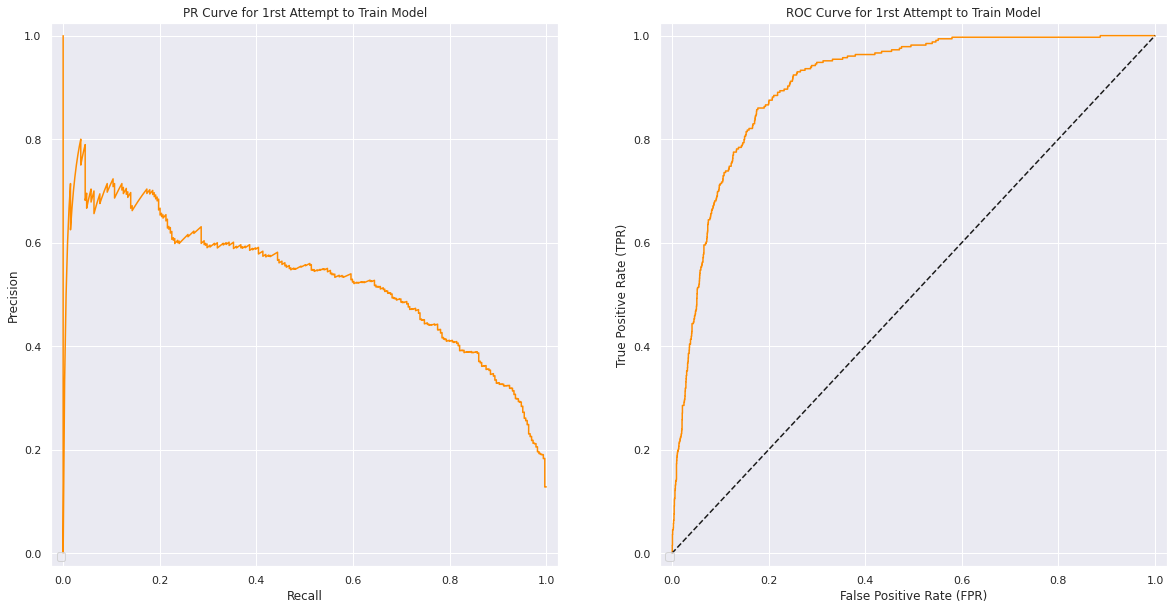

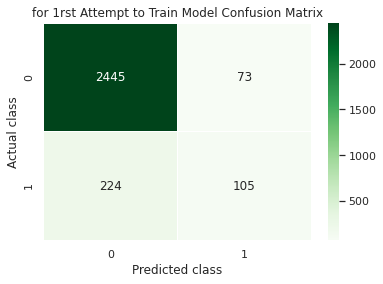



 Classification Report  for 1rst Attempt to Train Model 


              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2518
           1       0.59      0.32      0.41       329

    accuracy                           0.90      2847
   macro avg       0.75      0.65      0.68      2847
weighted avg       0.88      0.90      0.88      2847



In [29]:


report_clf(y_train, xgb_y_pred, xgb_cls_1_proba, title="for 1rst Attempt to Train Model", cmap="Greens")


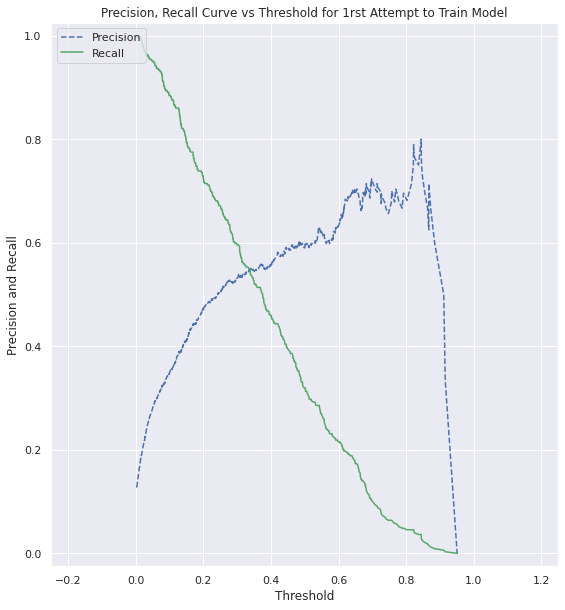

In [30]:
# plot the precision and recall against threshold


plot_pr_vs_th(y_train, xgb_cls_1_proba, show=True, tag="for 1rst Attempt to Train Model")



##### ROC Curve

1) We can see that ROC curve is not hugging the top left corner. So ROC curve is not giving use the proper lift. What's wrong with it? The main reason for this is the class imbalances. i.e number of positive testcase i.e user said yes and subscribed a term deposit is much less than people who said "no"

2) Typically in these cases of the imbalance class , you use the precision recall curve with a specific threshold, rather than roc curve, We will explore with the precision recall curve and the confusion matrix to solve the problem. 

##### Precision Recall Curve

1) As we pointed out that for the imbalance dataset, the precision recall curve is better.

2) if we want to find all the guys who are likely to accept the offer, we should aim for higher recall as explained in previous sections.


##### Confusion Matrix

1) For the imbalance data, we can see the confusion matrix is not balanced, i.e TPR and FPR are less.

2) We note that overall recall is 0.9 but for positive class (which we care more), it is only 0.38 and we would want to improve it.

##### precision and recall vs threshold

1) We also plotted, precision recall vs threshold and since for us recall is more important so we should choose our threshold accordingly.


### Strategy For Better Classifier for the Imbalance Data <a name="ml_clf_strategy"></a>

Can we do better than the current performance? The answer is yes and typically in these cases, we follow the following 
techniques.

1) Use the weighted class i.e give higher weight for the class 1 i.e 'yes'

2) OverSampling of the Minority class and Undersampling of the minority class

3) Use the SMOTE (synthetic Minority class oversampling)
   
   
   


### Second Attempt At Model Training using Weighted Samples<a name="ml_train_2"></a>

Lets use first approach i.e weighting the class to find the better model. The reason weighing the samples works is that we are saying to xgboost for a weight say 10, that consider each positive sample 10 times more important than 1 negative samples. In short, this is same as taking one positive sample and replicating it 10 times.


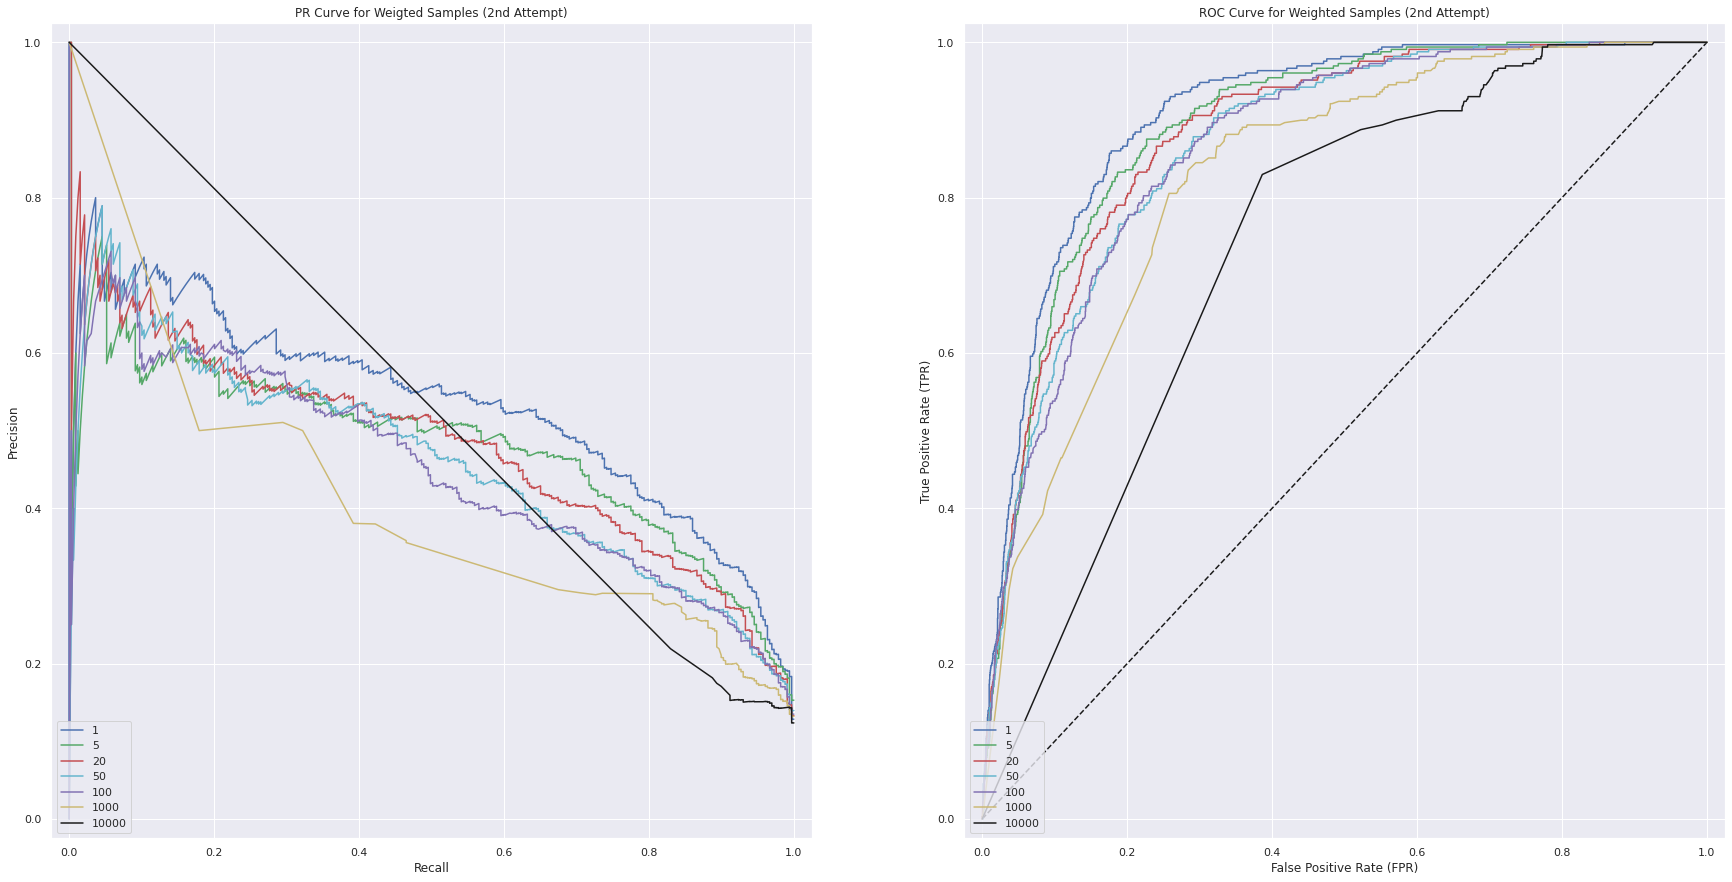

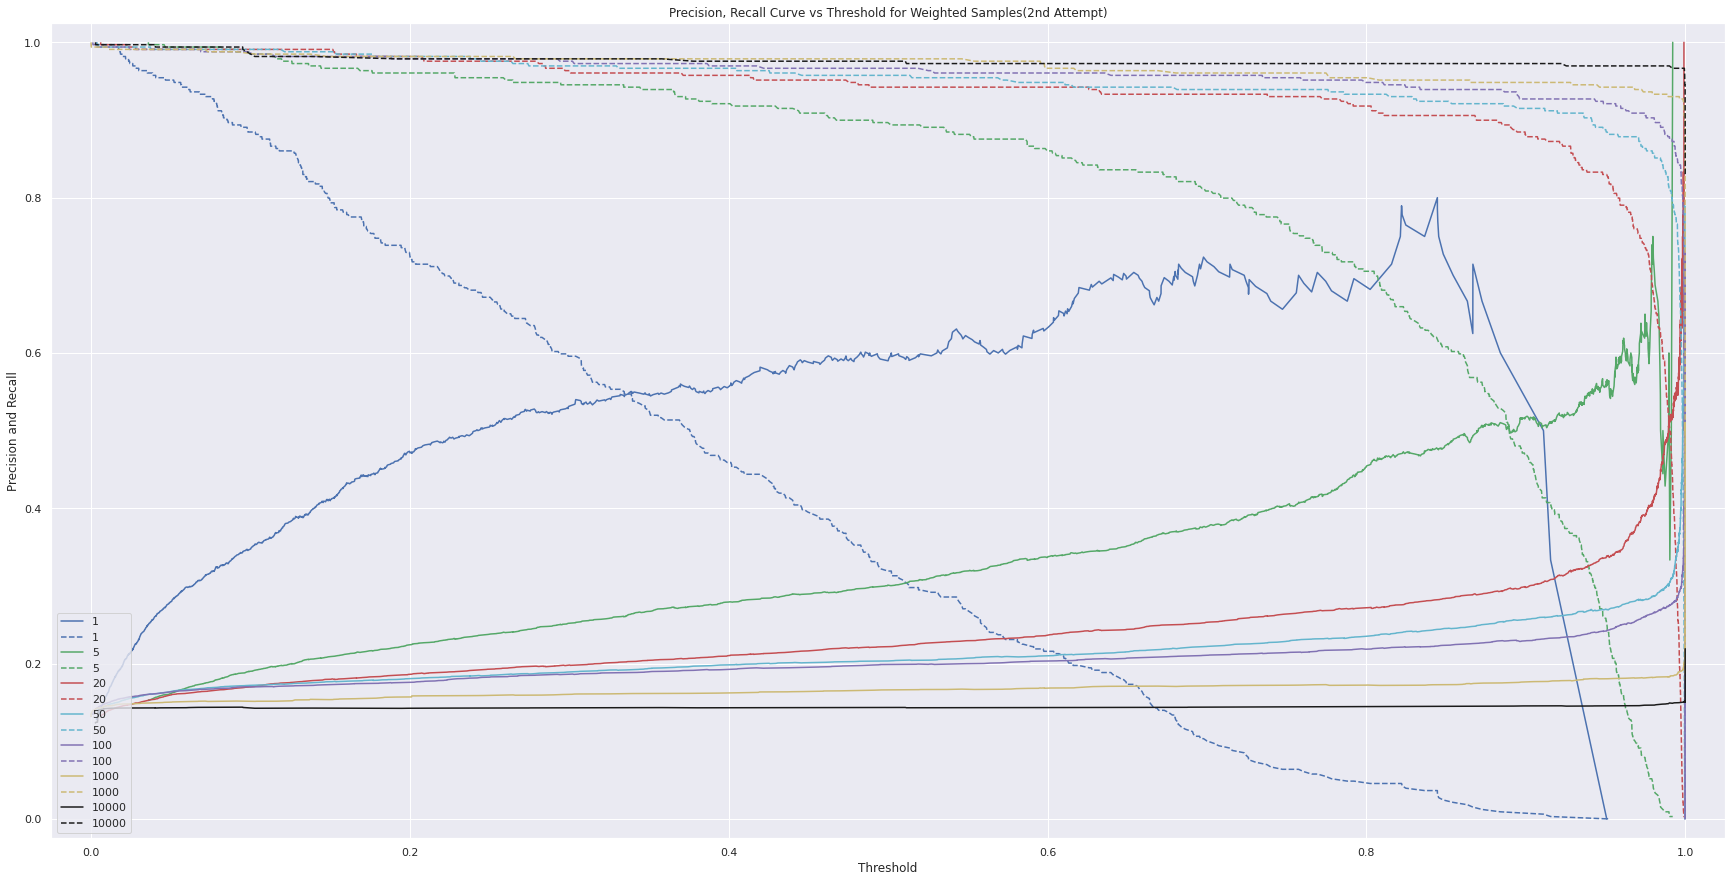

In [31]:



# setup the figure
fig1 = plt.figure(figsize=(30,15))

# plot one for PR curve
ax1 = fig1.add_subplot(1,2,1)
ax1.set_xlim([-0.025,1.025])
ax1.set_ylim([-0.025,1.025])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve for Weigted Samples (2nd Attempt)')

# plot 2 for ROC curve
ax2 = fig1.add_subplot(1,2,2)
ax2.set_xlim([-0.025,1.025])
ax2.set_ylim([-0.025,1.025])
ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC Curve for Weighted Samples (2nd Attempt)')

# plot the baseline ROC curve     
ax2.plot([0,1], [0,1], 'k--')
    

fig2 = plt.figure(figsize=(30,15))    
# plot 3 for precision recall vs threshold curve
ax3 = fig2.add_subplot(1,1,1)
ax3.set_xlim([-0.025,1.025])
ax3.set_ylim([-0.025,1.025])
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Precision and Recall')
ax3.set_title('Precision, Recall Curve vs Threshold for Weighted Samples(2nd Attempt)')


    

xgb_models = {}
# try various weights and plot on the same figure for better comparasion
for pos_sample_weight, color in zip([1,5,20,50,100, 1000, 10000],'bgrcmykw'):
  

  # create a model with pos_sample_weight and other default params
  xgb_model = create_xgb_clf({'scale_pos_weight':pos_sample_weight})
  
  # store the model for future use
  xgb_models[pos_sample_weight] = xgb_model
    
  # find the prediction with probabilities for pos_sample_weight
  xgb_predict_obj = find_cv_model_predict(xgb_model, X_train, y_train, weight=pos_sample_weight)

  xgb_cls_1_proba = xgb_predict_obj['proba'][:,1]
  xgb_y_pred = xgb_predict_obj['pred']
  y_act = y_train
  y_score = xgb_cls_1_proba
  label =  pos_sample_weight 
  pr,rc, pr_th = precision_recall_curve(y_act, y_score)
  tpr,fpr,_ = roc_curve(y_act, y_score)
    
  ax1.plot(rc,pr,c=color,label=label)
  ax2.plot(tpr,fpr,c=color,label=label)
 
  ax3.plot(pr_th,pr[:-1], c=color,label=label)
  ax3.plot(pr_th,rc[:-1], "--", c=color,label=label)
    
    
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
ax3.legend(loc='lower left')

plt.show()    

##### Analysis of Weighted model

We have seen how ROC curve is not helpful for class imbalance dataset. We usually rellies on Precision vs Recall curve and Precisio/Recall vs threshold.

We talked initially, how the recall is more important for our use case i.e we want to find all the people who are likely to accept the offer, even at some risk some of them rejecting it. 

Hence, we should have higher recall but good enough precision.

Lets look at bottom picture, (double click to enlarge) for Precision,Recall vs Threshold curve.
dashed lines are recall and solid lines are precision. We see that golden color lines have good balance of higher recall and good enough precision. Which corresponds to weight 1000.

For the weight of 1000 i,e golden line, both the top figure for ROC and Precision vs Recall curve is also reasonable and hence we will go with that weight.


Lets also see the confusion matrix and classification report for the best weighted models


No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0.99933976 0.9998653  0.4929911  ... 0.9999745  0.9999745  0.99732023]
[1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1
 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1
 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1]


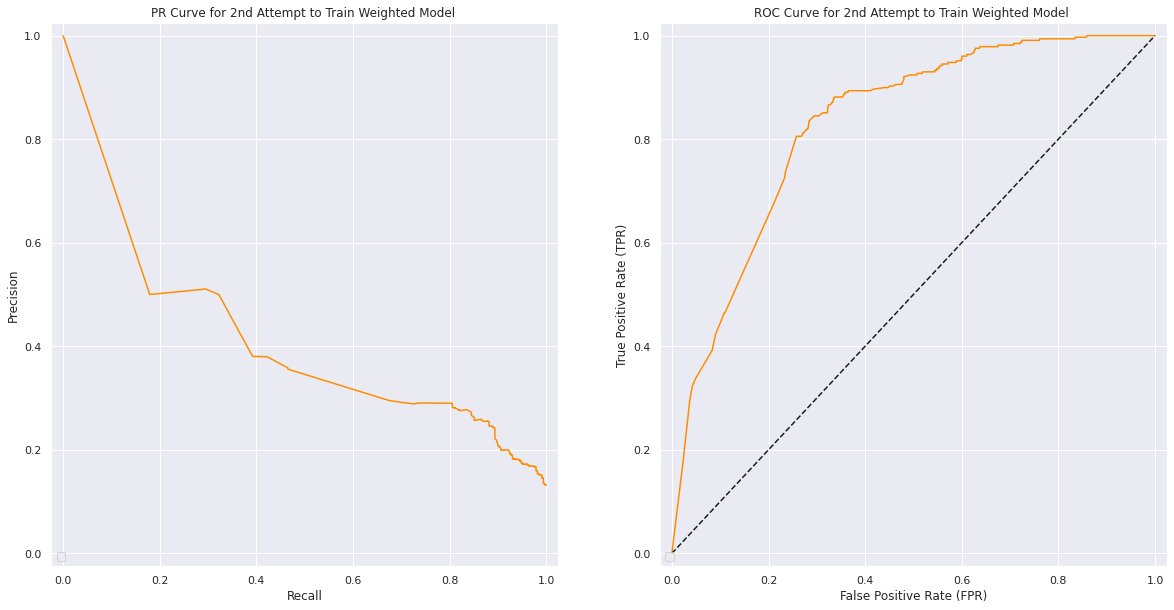

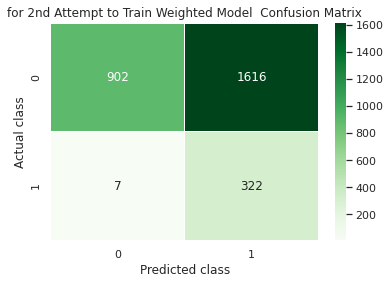



 Classification Report  for 2nd Attempt to Train Weighted Model  


              precision    recall  f1-score   support

           0       0.99      0.36      0.53      2518
           1       0.17      0.98      0.28       329

    accuracy                           0.43      2847
   macro avg       0.58      0.67      0.41      2847
weighted avg       0.90      0.43      0.50      2847



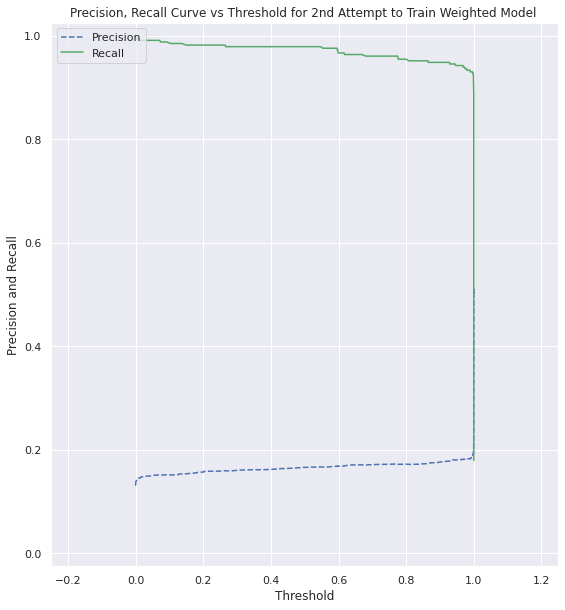

In [32]:
# get the best model with respect to recall
best_weight = 1000
xgb_model_best_wt_sofar = xgb_models[best_weight]


# use cross validation to find best model
xgb_predict_best_weighted_obj = find_cv_model_predict(xgb_model_best_wt_sofar, X_train, y_train, weight=best_weight)

xgb_best_wt_cls_1_proba = xgb_predict_best_weighted_obj['proba'][:,1]
xgb_best_wt_y_pred = xgb_predict_best_weighted_obj['pred']


print(xgb_best_wt_cls_1_proba)
print(xgb_best_wt_y_pred[10:100])

report_clf(y_train, xgb_best_wt_y_pred, xgb_best_wt_cls_1_proba, title="for 2nd Attempt to Train Weighted Model ", cmap="Greens")
plot_pr_vs_th(y_train, xgb_best_wt_cls_1_proba, show=True, tag="for 2nd Attempt to Train Weighted Model ")



**The key observation**, we make is that our best weighted model, the recall for positive class is 0.89 improvement from 0.38 but overall recall is reduced and it's ok as for yes recall for positive samples are more important


### Third Attempt at  Model Training using Weighted Samples and Feature Selection<a name="ml_train_3"></a> 


Now as we saw that weight 1000 is the best and we will use it. The next question, we ask is how can we make it better.
One of the things about the decision tree based model is that more the number of attributes, more noise is introduced i.e model won't generalize. So it is advisable to use only the important features for building.

We will classify using the important features to remove the noise.

1) We will find the important features

2) We will use it to classify again

3) plot the PR, ROC curve.


##### Plot feature importance

Before we proceed to optimize the code, lets plot feature importance for our best model so far.


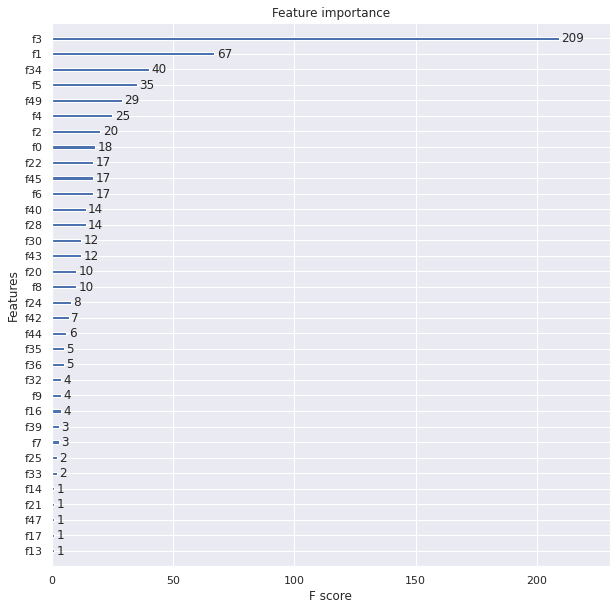

Feature importance =  [0.01518535 0.01596513 0.0266428  0.03559307 0.03938653 0.00793505
 0.00440957 0.00895522 0.0808572  0.02604676 0.         0.
 0.         0.05637347 0.01865302 0.         0.0630613  0.01955554
 0.         0.         0.00100244 0.00800338 0.0035282  0.
 0.00473304 0.00097212 0.         0.         0.04582606 0.
 0.03869453 0.         0.05448056 0.01209503 0.06257816 0.03783967
 0.04330549 0.         0.         0.02382642 0.03084915 0.
 0.0152625  0.0653403  0.04334966 0.03643618 0.         0.02749069
 0.         0.02576645 0.        ]
Sorted Feature importance =  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00097212
 0.00100244 0.0035282  0.00440957 0.00473304 0.00793505 0.00800338
 0.00895522 0.01209503 0.01518535 0.0152625  0.01596513 0.01865302
 0.01955554 0.02382642 0.02576645 0.02604676 0.0266428  0.02749069
 0.03084915 0.03559307 0

In [33]:




#xgb_model.fit(X_train, y_train, eval_metric='auc')

# get the best model with respect to recall
best_weight = 1000
xgb_model_best_sofar = xgb_models[best_weight]

# fit the whole training set. We will later run for the better model later, but for now. Lets go with it.
xgb_model_best_sofar.fit(X_train, y_train, eval_metric='auc')


# fit the model just in case
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(1,1,1)

plot_importance(xgb_model_best_sofar, ax=ax1)


# need graph viz package
#ax2 = fig.add_subplot(1,2,2)
#plot_tree(xgb_model, ax=ax2)

plt.show()

print("Feature importance = ", xgb_model_best_sofar.feature_importances_)
print("Sorted Feature importance = ", np.sort(xgb_model_best_sofar.feature_importances_))




We can see that not all features are important and may be our model is better, if we use only the selected features
Lets try it out.


We have transformer [SelectFromModel](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) which will select the features based on threshold.


Now, we won't know what threshold, we should use for selecting the list of features. So we will perform the grid search using our custom code. 

We will plot various performance metrics and use visual inspection to find the best threshold.


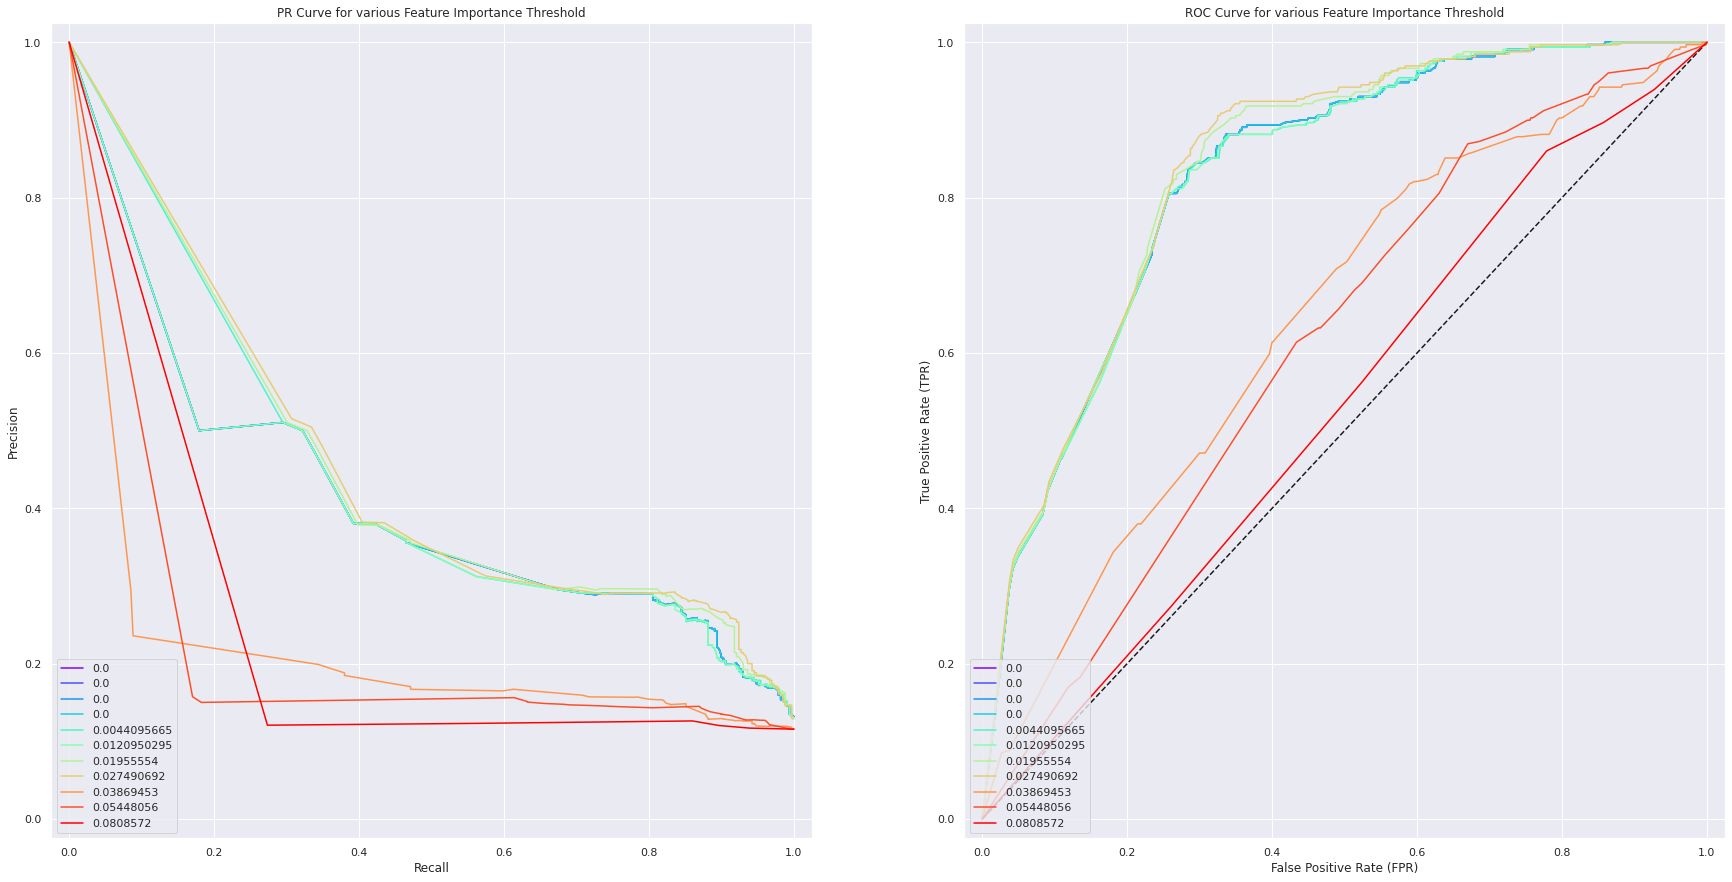

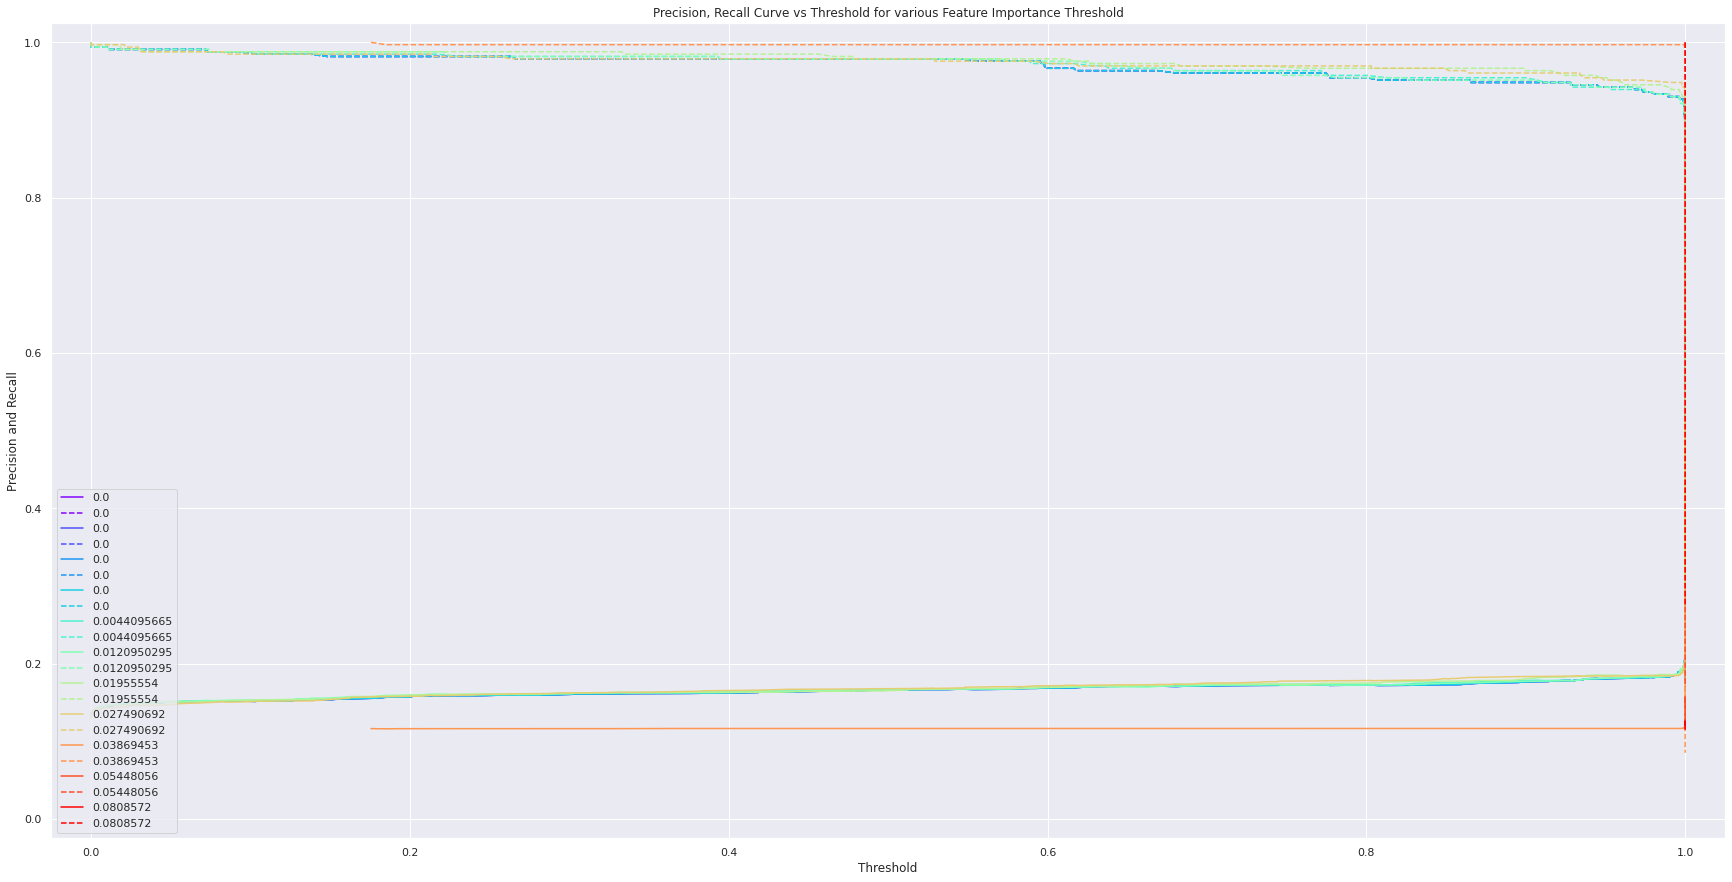

In [34]:


# setup the figure
fig1 = plt.figure(figsize=(30,15))

# plot one for PR curve
ax1 = fig1.add_subplot(1,2,1)
ax1.set_xlim([-0.025,1.025])
ax1.set_ylim([-0.025,1.025])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve for various Feature Importance Threshold')

# plot 2 for ROC curve
ax2 = fig1.add_subplot(1,2,2)
ax2.set_xlim([-0.025,1.025])
ax2.set_ylim([-0.025,1.025])
ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC Curve for various Feature Importance Threshold')

# plot the baseline ROC curve     
ax2.plot([0,1], [0,1], 'k--')
    

fig2 = plt.figure(figsize=(30,15))    
# plot 3 for precision recall vs threshold curve
ax3 = fig2.add_subplot(1,1,1)
ax3.set_xlim([-0.025,1.025])
ax3.set_ylim([-0.025,1.025])
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Precision and Recall')
ax3.set_title('Precision, Recall Curve vs Threshold for various Feature Importance Threshold')



#lets explore various thresholds.
fi_thresholds = xgb_model_best_sofar.feature_importances_

fi_ths_sorted = np.sort(fi_thresholds)
ths_size = len(fi_ths_sorted)
ths_lim = 10 # threshold limits i.e the various values we want to try out.
if ths_size > ths_lim:
    # select only the thresholds
    step = int(len(fi_ths_sorted)/ths_lim)
    fi_ths_sorted = [fi_ths_sorted[i] for i in range(0, len(fi_ths_sorted), step)]
      
ths_size = len(fi_ths_sorted)   
colors = plt.cm.rainbow(np.linspace(0,1, ths_size))
        
# from best_weights
xgb_models_bm_fi = {}
select_txfs = {}
# try various weights and plot on the same figure for better comparasion
for fi_th, color in zip(fi_ths_sorted, colors):
  

  # train a transformer to select a feature based on threshold 50
  select_txf = SelectFromModel(xgb_model_best_sofar, threshold=fi_th, prefit=True)

  select_X_train = select_txf.transform(X_train)
  select_txfs[fi_th] = select_txf


  # create a model with pos_sample_weight and other default params
  xgb_model = create_xgb_clf({'scale_pos_weight':best_weight})
  
  # store the model for future use
  xgb_models_bm_fi[fi_th] = xgb_model
    
  # find the prediction with probabilities for pos_sample_weight
  xgb_predict_obj = find_cv_model_predict(xgb_model, select_X_train, y_train, weight=best_weight)

  xgb_cls_1_proba = xgb_predict_obj['proba'][:,1]
  xgb_y_pred = xgb_predict_obj['pred']
  y_act = y_train
  y_score = xgb_cls_1_proba
  label =  fi_th
  pr,rc, pr_th = precision_recall_curve(y_act, y_score)
  tpr,fpr,_ = roc_curve(y_act, y_score)
    
  ax1.plot(rc,pr,c=color,label=label)
  ax2.plot(tpr,fpr,c=color,label=label)
 
  ax3.plot(pr_th,pr[:-1], c=color,label=label)
  ax3.plot(pr_th,rc[:-1], "--", c=color,label=label)
    
    
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
ax3.legend(loc='lower left')

plt.show()    

we don't want to chose red one as it is too much overfitting.

If we chose bluish green color corresponding to threshold 0.008, we get reasonable performance for recall and precision. 


##### Analysis of the Weighted Model with Feature Selection.

Lets use 0.008 threshold to plot again various metrics especially classificaion report and see how are we going compare to our [weighted model](#ml_train_2)

We will plot various performance metrics first as we have done in previous sections



In [35]:
# train a transformer to select a feature based on threshold 50
select_txf = SelectFromModel(xgb_model_best_sofar, threshold=0.008, prefit=True)

select_X_train = select_txf.transform(X_train)



In [36]:

xgb_model_weighted = create_xgb_clf({'scale_pos_weight':best_weight})


#xgb_predict_obj = find_cv_model_predict(xgb_model, X_train, y_train, weight=1)
# use cross validation to find best model
xgb_predict_weighted_obj = find_cv_model_predict(xgb_model_weighted, select_X_train, y_train, weight=best_weight)

xgb_wt_cls_1_proba = xgb_predict_weighted_obj['proba'][:,1]
xgb_wt_y_pred = xgb_predict_weighted_obj['pred']


print(xgb_wt_cls_1_proba)
print(xgb_wt_y_pred[10:100])

[0.99933976 0.9998653  0.4929887  ... 0.99997437 0.99997437 0.99996877]
[1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1
 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1
 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


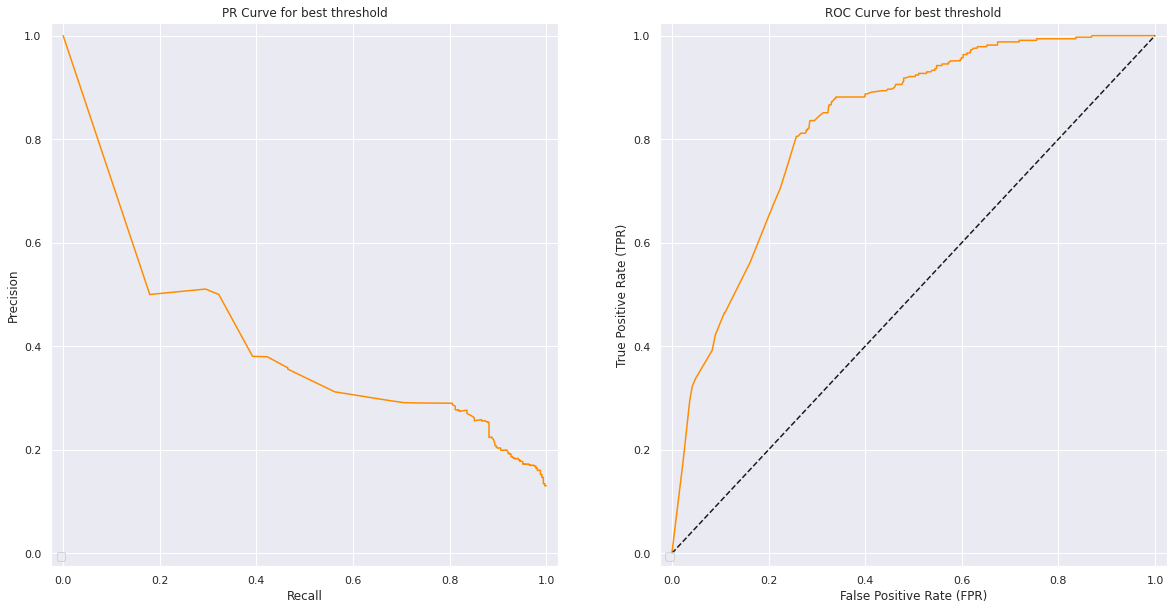

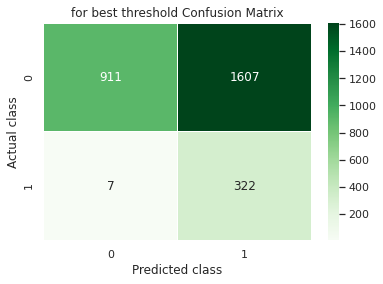



 Classification Report  for best threshold 


              precision    recall  f1-score   support

           0       0.99      0.36      0.53      2518
           1       0.17      0.98      0.29       329

    accuracy                           0.43      2847
   macro avg       0.58      0.67      0.41      2847
weighted avg       0.90      0.43      0.50      2847



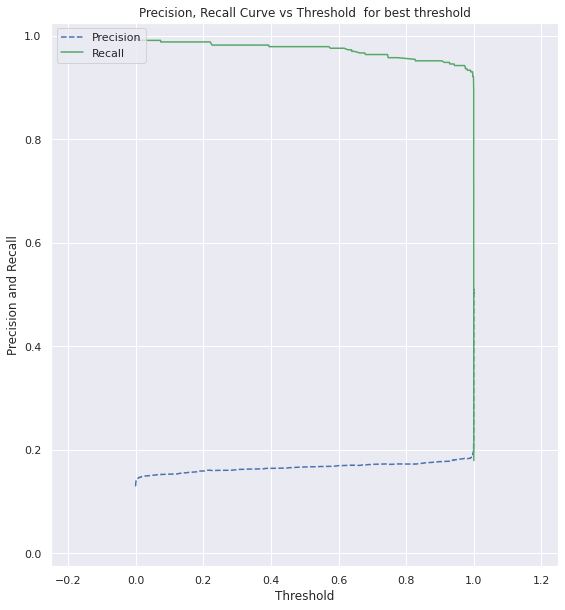

In [37]:
report_clf(y_train, xgb_wt_y_pred, xgb_wt_cls_1_proba, title="for best threshold", cmap="Greens")
plot_pr_vs_th(y_train, xgb_wt_cls_1_proba, show=True, tag=" for best threshold")



1) Compare to weighted model using a subset of features does improve a small bit of recall for positive class from 0.89 to 0.9 and also overall recall from 0.7 to 0.71.

2) Feature Selection is important techniques for improving classification performance. Since decision based models are robust to features, for this case, we don't see much improvement in performance for feature selection.If we had differnt models say logistic regression, we would see a much bigger improvement.



# Generalization and Prediction <a name="ml_predict"></a>

Now we have trained our model and we are ready to do inference. Note that in a real application. Once the model is trained , we will export it and deploy on the production machine. But for the purpose of this notebook, we will run it on the hold out data. Note that we didn't even use the held out data for cross validation since doing that would bias our model. So running it on the hold out dataset, will truly tell us generalization of the model.


###### prepare test data using ML pipeline

Lets now run the same pipeline we created before to prepare our test data.



In [38]:



X_gen_test = X_pipeline.transform(data_raw_test)
print("\n\nShape of the transformed data. Note that increased in the number of columns due to one hot encoding\n")
print("\nOriginal data shape (num_rows, num_cols) == ")
print(data_raw_test.shape)
print("\nTransformed data shape (num_rows, num_cols) == ")
print(X_gen_test.shape)
print("\n\n Sample of transformed inputs\n", X, "\n")




Shape of the transformed data. Note that increased in the number of columns due to one hot encoding


Original data shape (num_rows, num_cols) == 
(453, 17)

Transformed data shape (num_rows, num_cols) == 
(453, 51)


 Sample of transformed inputs
 [[-0.6734285  -0.4727389   0.12702873 ...  0.          0.
   1.        ]
 [-1.23973489  1.14925852 -0.35693557 ...  0.          0.
   1.        ]
 [ 3.57386941  0.39066179 -0.96189094 ...  0.          0.
   0.        ]
 ...
 [ 1.11987506 -0.37220594  1.45793055 ...  0.          1.
   0.        ]
 [-0.8621973  -0.26181681 -0.96189094 ...  0.          0.
   1.        ]
 [ 0.36479988 -0.57852848 -0.84089986 ...  0.          0.
   1.        ]] 



In [39]:

y_gen_test = y_pipeline.transform(data_raw_test)


print("\nSample of original output = ", data_raw_test['y'].values.reshape(-1)[:20], "\n")
print("\nSample of transformed output = ", y_gen_test[:20], "\n")



Sample of original output =  ['no' 'no' 'no' 'no' 'no' 'yes' 'no' 'no' 'no' 'yes' 'no' 'no' 'no' 'no'
 'no' 'no' 'no' 'no' 'no' 'no'] 


Sample of transformed output =  [0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0] 



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Run the best model for prediction

1) Train on whole training set with best weight and best threshold.

2) test on held out test set.


In [40]:
best_threshold = 0.008
select_txf3 = SelectFromModel(xgb_model_best_sofar, threshold=best_threshold, prefit=True)

select_X_train = select_txf3.transform(X_train)

xgb_model_gen = create_xgb_clf({'scale_pos_weight': best_weight})


 # get the weights of w of size y
y_wts = create_xgb_weights(best_weight, X, y)

xgb_model_gen.fit(select_X_train, y_train, sample_weight=y_wts)

select_X_test = select_txf3.transform(X_gen_test)

y_test_proba = xgb_model_gen.predict_proba(select_X_test)
y_test_pred = xgb_model_gen.predict(select_X_test)



y_test_cls_1_proba = y_test_proba[:,1]
y_test_cls_1_pred = y_test_pred

No handles with labels found to put in legend.
No handles with labels found to put in legend.


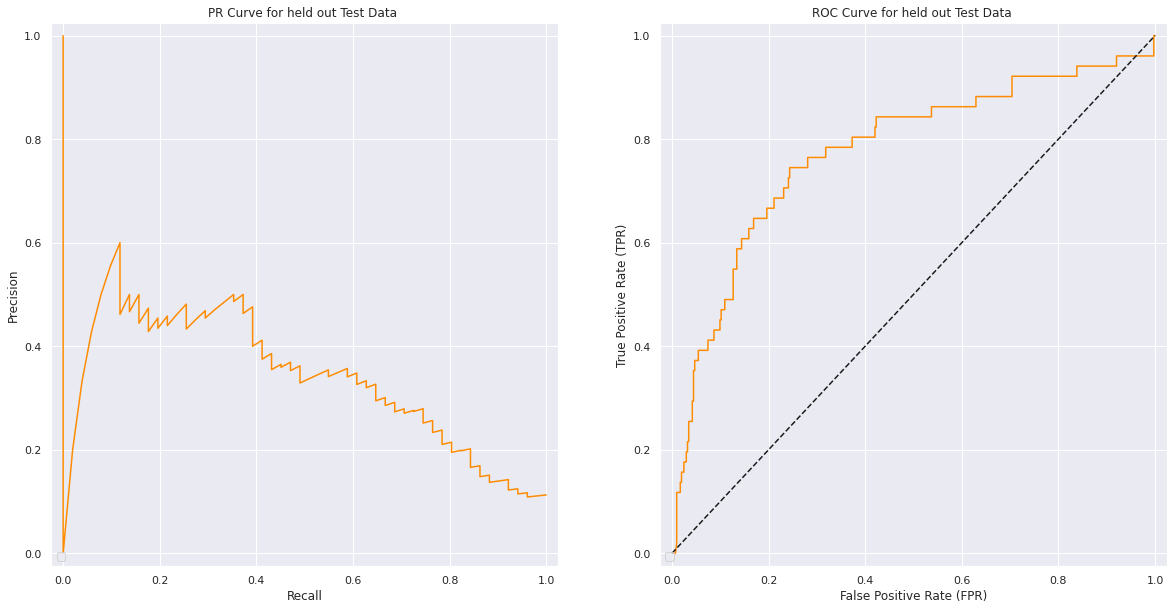

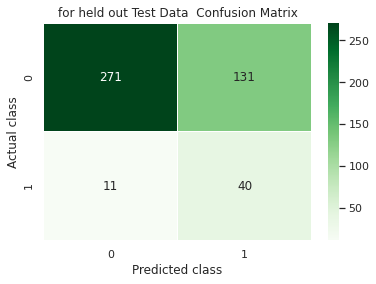



 Classification Report  for held out Test Data  


              precision    recall  f1-score   support

           0       0.96      0.67      0.79       402
           1       0.23      0.78      0.36        51

    accuracy                           0.69       453
   macro avg       0.60      0.73      0.58       453
weighted avg       0.88      0.69      0.74       453



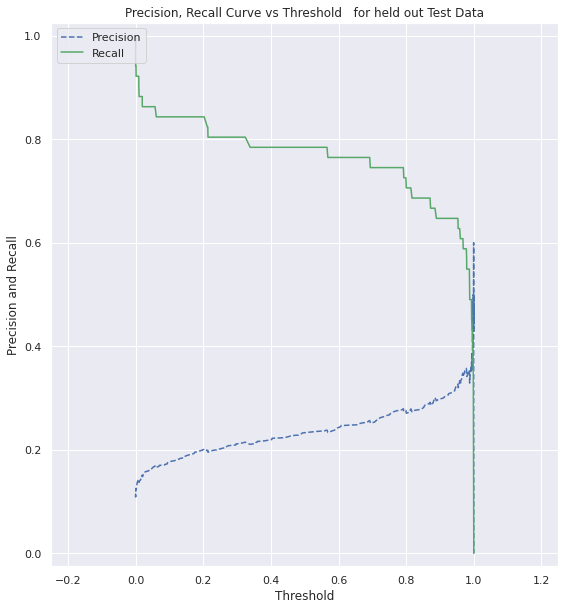

In [41]:
report_clf(y_gen_test, y_test_cls_1_pred, y_test_cls_1_proba, title="for held out Test Data ", cmap="Greens")
plot_pr_vs_th(y_gen_test, y_test_cls_1_proba, show=True, tag="  for held out Test Data")

##### Analysis of Model Prediction on held out test data

For We note that overall, recall is better (0.82) and positive class recall is 0.63.



# Summary <a name="summary"></a>

Thus, we looked at various ways of improving the model performance.

First of all, for the class imbalance dataset, accuracy and ROC curve is not useful. So we use Precision vs Recall and Precision Recall vs threshold. Depending on the business use cases, we have to improve recall or precision. In our case, we improved recall metric without sacrificing too much of precision.

We did three iterations for improving model performance using three different techniques

1) Use the good parameters to build xgboost model 

2) Use the weighted samples to build a better model

3) Since we were using almost all the 50 features, we were probably overfitting, so we plotting feature importance 
 and found the best set of the features to improve the overall recall score
 



# Other methods for improving for class imbalance. <a name="other_techniques"></a>

The performance of classification model for class imbalances can be improve further.
However, In this notebook, we will not explore the oversampling method and SMOTE method but we will give a short
description on what they are

1) **Oversampling of minority class and Undersampling of majority class.**

As the name implies, this is just the straightforward procedure and following scikit function can be used.See [References](#references) for examples.


2) **SMOTE method.**

Problem with weighted and Over and Under Sampling methods are that the same data is reused and the better approach 
is to generate a new sample based on the two samples. One in the positive class and one in the negative class and use
interpolation and k nearest neighbour to generate new samples between the decision boundry, that is basically the idea of SMOTE method. Scikit learn has method for this. See [References](#references) for SMOTE examples and SMOTE paper.



# References <a name="references"></a>


* [Scikit Learn](http://scikit-learn.org/stable/)

* [Pandas](https://pandas.pydata.org/)

* [Matplotlib](https://matplotlib.org/)

* [SeaBorn](https://seaborn.pydata.org/)

* [XGBoost](https://github.com/dmlc/xgboost)

* [SMOTE Paper](https://www.jair.org/media/953/live-953-2037-jair.pdf)

* [SMOTE Example](http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/over-sampling/plot_smote.html)

* [Over Sampling Example](http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html)

* [Under Sampling Example](http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/under-sampling/plot_random_under_sampler.html)
